In [52]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, fetch_olivetti_faces

iris = load_iris()            #iris.data, iris.target
wine = load_wine()            #wine.data, wine.target
WDPC = load_breast_cancer()   #WDPC.data, WDPC.target
faces = fetch_olivetti_faces()   #400 pictures with 40 people! Not 5 as in the paper


In [57]:
from collections import Counter

Counter(WDPC.target)

Counter({0: 212, 1: 357})

In [3]:
import pandas as pd

data = pd.read_csv('glass.csv')
X, y = data.drop('Type', axis=1), data.Type

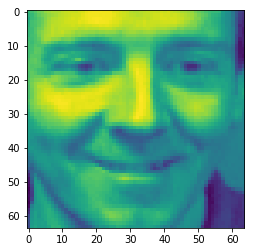

In [21]:
import matplotlib.pyplot as plt
plt.imshow(faces.images[20])

In [15]:
from information import ITPC

<300x300 sparse matrix of type '<class 'numpy.float64'>'
	with 8242 stored elements in Compressed Sparse Row format>

<300x300 sparse matrix of type '<class 'numpy.float64'>'
	with 8032 stored elements in Compressed Sparse Row format>

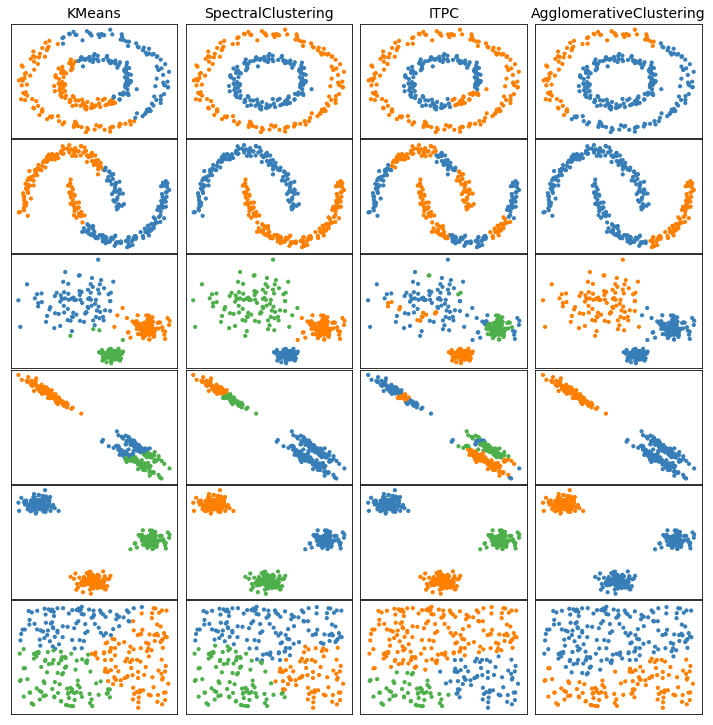

In [20]:
# the modified code from sklearn

# when we use itpc with rbf kernel

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

n_samples = 300
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=200, cluster_std=0.5)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropically distributed data
random_state = 200
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(4 * 2 + 2, 10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    two_means = cluster.KMeans(n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    itpc = ITPC(n_clusters=params['n_clusters'], gamma = 5, random_state=0, verbose=False)
    
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ward_linkage = cluster.AgglomerativeClustering(connectivity=connectivity)

    clustering_algorithms = (
        ('KMeans', two_means),
        ('SpectralClustering', spectral),
        ('ITPC', itpc),
        ('AgglomerativeClustering', ward_linkage),
    )
    
    gammas = [10, 20, 3, 7, 5, 30]
    
    for name, algorithm in clustering_algorithms:
        if algorithm == itpc:
            if i_dataset == 0 or i_dataset == 1:
                algorithm.set_params(affinity =  'nearest_neighbors', n_neighbors=25, random_state=16) 
#            print('gamma = ', gammas[i_dataset])
            else:
                algorithm.set_params(gamma = gammas[i_dataset])
        algorithm.fit(X)
    
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()